<a href="https://colab.research.google.com/github/alexandrulascu/Cresa---WPF-application/blob/master/Tema3_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu


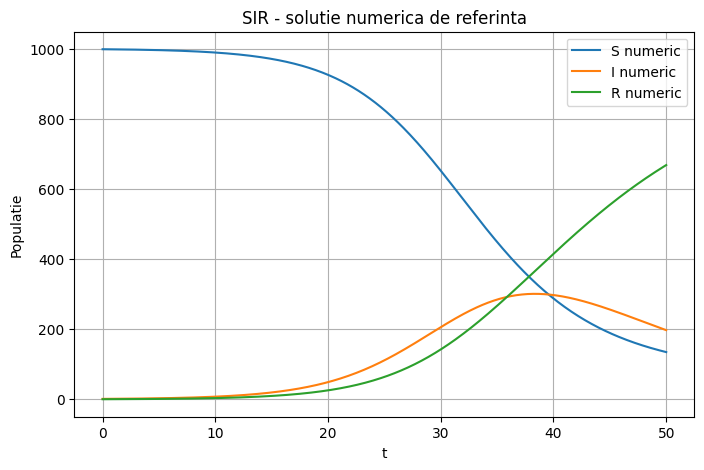

In [2]:
!pip install torch --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


beta_true = 0.3
gamma_true = 0.1
N_pop = 1000.0

S0 = 999.0
I0 = 1.0
R0 = 0.0


def sir_rhs_numpy(t, y, params):
    S, I, R = y
    beta = params["beta"]
    gamma = params["gamma"]
    N = params["N"]
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return np.array([dSdt, dIdt, dRdt])

def rk4_step_numpy(f, t, y, h, params):
    k1 = f(t, y, params)
    k2 = f(t + h/2, y + h*k1/2, params)
    k3 = f(t + h/2, y + h*k2/2, params)
    k4 = f(t + h, y + h*k3, params)
    return y + h*(k1 + 2*k2 + 2*k3 + k4)/6

def solve_sir_numpy(t0, t_end, y0, h, params):
    n = int((t_end - t0)/h)
    t = np.linspace(t0, t_end, n+1)
    y = np.zeros((n+1, 3))
    y[0] = y0
    for i in range(n):
        y[i+1] = rk4_step_numpy(sir_rhs_numpy, t[i], y[i], h, params)
    return t, y

params_true = {"beta": beta_true, "gamma": gamma_true, "N": N_pop}
t_ref, y_ref = solve_sir_numpy(0.0, 50.0, np.array([S0, I0, R0]), 0.1, params_true)

plt.figure(figsize=(8,5))
plt.plot(t_ref, y_ref[:,0], label='S numeric')
plt.plot(t_ref, y_ref[:,1], label='I numeric')
plt.plot(t_ref, y_ref[:,2], label='R numeric')
plt.legend(); plt.grid(); plt.xlabel('t'); plt.ylabel('Populatie'); plt.title('SIR - solutie numerica de referinta')
plt.show()


In [3]:
class SIR_PINN(nn.Module):
    def __init__(self, n_hidden=4, n_neurons=32):
        super(SIR_PINN, self).__init__()

        layers = []
        input_dim = 1
        output_dim = 3

        layers.append(nn.Linear(input_dim, n_neurons))
        layers.append(nn.Tanh())

        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(n_neurons, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

pinn = SIR_PINN().to(device)
print(pinn)


SIR_PINN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [4]:
def pinn_residuals(pinn, t_colloc):
    """
    Calculeaza reziduurile f1, f2, f3 pentru toate punctele de coliziune (collocation points)
    t_colloc: tensor (N_c, 1) cu requires_grad=True
    """
    t_colloc = t_colloc.to(device)
    t_colloc.requires_grad_(True)

    SIR = pinn(t_colloc)
    S = SIR[:,0:1]
    I = SIR[:,1:2]
    R = SIR[:,2:3]

    dSdt = torch.autograd.grad(S, t_colloc, torch.ones_like(S), retain_graph=True, create_graph=True)[0]
    dIdt = torch.autograd.grad(I, t_colloc, torch.ones_like(I), retain_graph=True, create_graph=True)[0]
    dRdt = torch.autograd.grad(R, t_colloc, torch.ones_like(R), retain_graph=True, create_graph=True)[0]

    beta = beta_true
    gamma = gamma_true
    N = N_pop

    f1 = dSdt + beta * S * I / N
    f2 = dIdt - beta * S * I / N + gamma * I
    f3 = dRdt - gamma * I

    return f1, f2, f3, S, I, R

def pinn_loss(pinn, t_colloc, lambda_ic=10.0):
    f1, f2, f3, S_pred, I_pred, R_pred = pinn_residuals(pinn, t_colloc)

    loss_f = torch.mean(f1**2) + torch.mean(f2**2) + torch.mean(f3**2)

    t0 = torch.zeros((1,1), dtype=torch.float32).to(device)
    SIR0 = pinn(t0)
    S0_pred = SIR0[0,0]
    I0_pred = SIR0[0,1]
    R0_pred = SIR0[0,2]

    loss_ic = (S0_pred - S0)**2 + (I0_pred - I0)**2 + (R0_pred - R0)**2

    loss = loss_f + lambda_ic * loss_ic
    return loss, loss_f.item(), loss_ic.item()


In [5]:
T_final = 50.0
N_c = 200
t_colloc = torch.linspace(0.0, T_final, N_c).view(-1,1).to(device)

optimizer = optim.Adam(pinn.parameters(), lr=1e-3)

n_epochs = 5000
history = []

for epoch in range(1, n_epochs+1):
    optimizer.zero_grad()
    loss, loss_f_val, loss_ic_val = pinn_loss(pinn, t_colloc, lambda_ic=10.0)
    loss.backward()
    optimizer.step()

    history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss={loss.item():.4e}, Loss_f={loss_f_val:.4e}, Loss_ic={loss_ic_val:.4e}")


Epoch 500/5000, Loss=9.5712e+06, Loss_f=1.8512e-02, Loss_ic=9.5712e+05
Epoch 1000/5000, Loss=9.2487e+06, Loss_f=1.7485e-02, Loss_ic=9.2487e+05
Epoch 1500/5000, Loss=8.9368e+06, Loss_f=1.6741e-02, Loss_ic=8.9368e+05
Epoch 2000/5000, Loss=8.6329e+06, Loss_f=1.6023e-02, Loss_ic=8.6329e+05
Epoch 2500/5000, Loss=8.3359e+06, Loss_f=1.5357e-02, Loss_ic=8.3359e+05
Epoch 3000/5000, Loss=8.0452e+06, Loss_f=1.4733e-02, Loss_ic=8.0452e+05
Epoch 3500/5000, Loss=7.7605e+06, Loss_f=1.4124e-02, Loss_ic=7.7605e+05
Epoch 4000/5000, Loss=7.4817e+06, Loss_f=1.3595e-02, Loss_ic=7.4817e+05
Epoch 4500/5000, Loss=7.2084e+06, Loss_f=1.3142e-02, Loss_ic=7.2084e+05
Epoch 5000/5000, Loss=6.9406e+06, Loss_f=1.2735e-02, Loss_ic=6.9406e+05


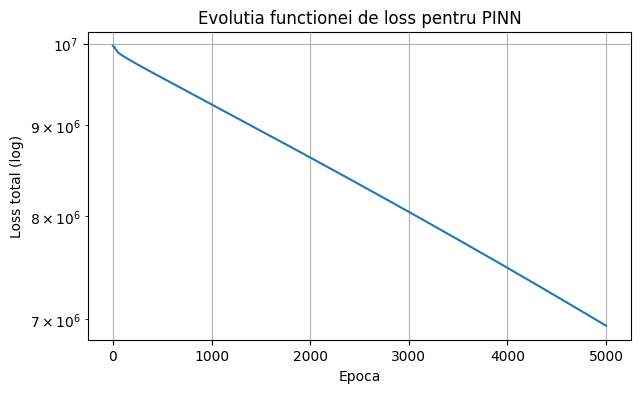

In [6]:
plt.figure(figsize=(7,4))
plt.semilogy(history)
plt.xlabel('Epoca')
plt.ylabel('Loss total (log)')
plt.title('Evolutia functionei de loss pentru PINN')
plt.grid(True)
plt.show()


Eroare maxima S: 833.07
Eroare maxima I: 299.80
Eroare maxima R: 668.35


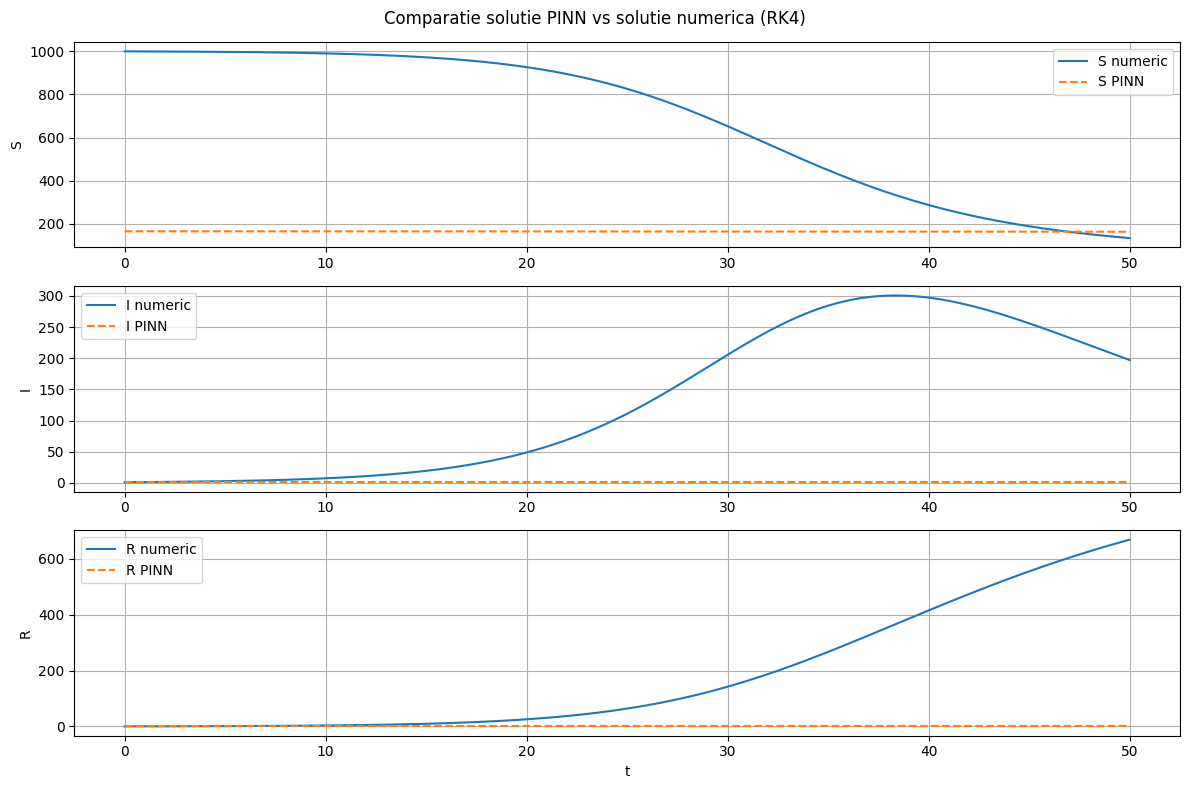

In [7]:
t_eval = torch.tensor(t_ref, dtype=torch.float32).view(-1,1).to(device)
with torch.no_grad():
    SIR_pinn = pinn(t_eval).cpu().numpy()

S_pinn = SIR_pinn[:,0]
I_pinn = SIR_pinn[:,1]
R_pinn = SIR_pinn[:,2]

S_true = y_ref[:,0]
I_true = y_ref[:,1]
R_true = y_ref[:,2]

err_S = np.max(np.abs(S_pinn - S_true))
err_I = np.max(np.abs(I_pinn - I_true))
err_R = np.max(np.abs(R_pinn - R_true))
print(f"Eroare maxima S: {err_S:.2f}")
print(f"Eroare maxima I: {err_I:.2f}")
print(f"Eroare maxima R: {err_R:.2f}")

plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(t_ref, S_true, label='S numeric')
plt.plot(t_ref, S_pinn, '--', label='S PINN')
plt.legend(); plt.grid(); plt.ylabel('S')

plt.subplot(3,1,2)
plt.plot(t_ref, I_true, label='I numeric')
plt.plot(t_ref, I_pinn, '--', label='I PINN')
plt.legend(); plt.grid(); plt.ylabel('I')

plt.subplot(3,1,3)
plt.plot(t_ref, R_true, label='R numeric')
plt.plot(t_ref, R_pinn, '--', label='R PINN')
plt.legend(); plt.grid(); plt.ylabel('R'); plt.xlabel('t')

plt.suptitle('Comparatie solutie PINN vs solutie numerica (RK4)')
plt.tight_layout()
plt.show()
